In [17]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import dates as mdates
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [2]:
file_path = r'C:\Users\alvar\Githubs\threads-automation\data\todos_simple.json'

with open(file_path, 'r', encoding='utf-8-sig') as file:
        todos_data = json.load(file)
    
df = pd.DataFrame(todos_data)
df.shape

(5607, 7)

In [3]:
my_thoughts = df[df['FolderName'] == 'My thoughts']
my_thoughts.shape

(838, 7)

In [4]:
my_thoughts.iloc[0]

Subject                     orgullo cálido
Body                                      
IsComplete                           False
Creator               Álvaro Francisco Gil
FolderName                     My thoughts
DateOfCreation         2025-03-28T11:36:42
DateOfModification     2025-03-28T11:36:42
Name: 1234, dtype: object

In [5]:
# Count columns with NaN values in my_thoughts and remove them
nan_counts = my_thoughts.isna().sum()
print("Columns with NaN values:")
print(nan_counts[nan_counts > 0])

# Remove columns that have any NaN values
my_thoughts = my_thoughts.dropna(axis=1)


Columns with NaN values:
Series([], dtype: int64)


In [6]:
my_thoughts.head()

,Subject,Body,IsComplete,Creator,FolderName,DateOfCreation,DateOfModification
1234,orgullo cálido,,False,Álvaro Francisco Gil,My thoughts,2025-03-28T11:36:42,2025-03-28T11:36:42
1235,los pensamientos se deslizan por mi pelo como ...,,False,Álvaro Francisco Gil,My thoughts,2025-03-28T11:36:42,2025-03-28T11:36:42
1236,"vuelvo a Madrid con ganas, pero no las suficie...",mar 27,False,Álvaro Francisco Gil,My thoughts,2025-03-28T10:26:29,2025-03-28T10:29:29
1237,every art production is a diary entry,,False,Álvaro Francisco Gil,My thoughts,2025-03-27T17:25:39,2025-03-27T17:25:50
1238,¿te puedes creer que cuando cierro los ojos so...,,False,Álvaro Francisco Gil,My thoughts,2025-03-25T20:58:22,2025-03-25T20:58:22


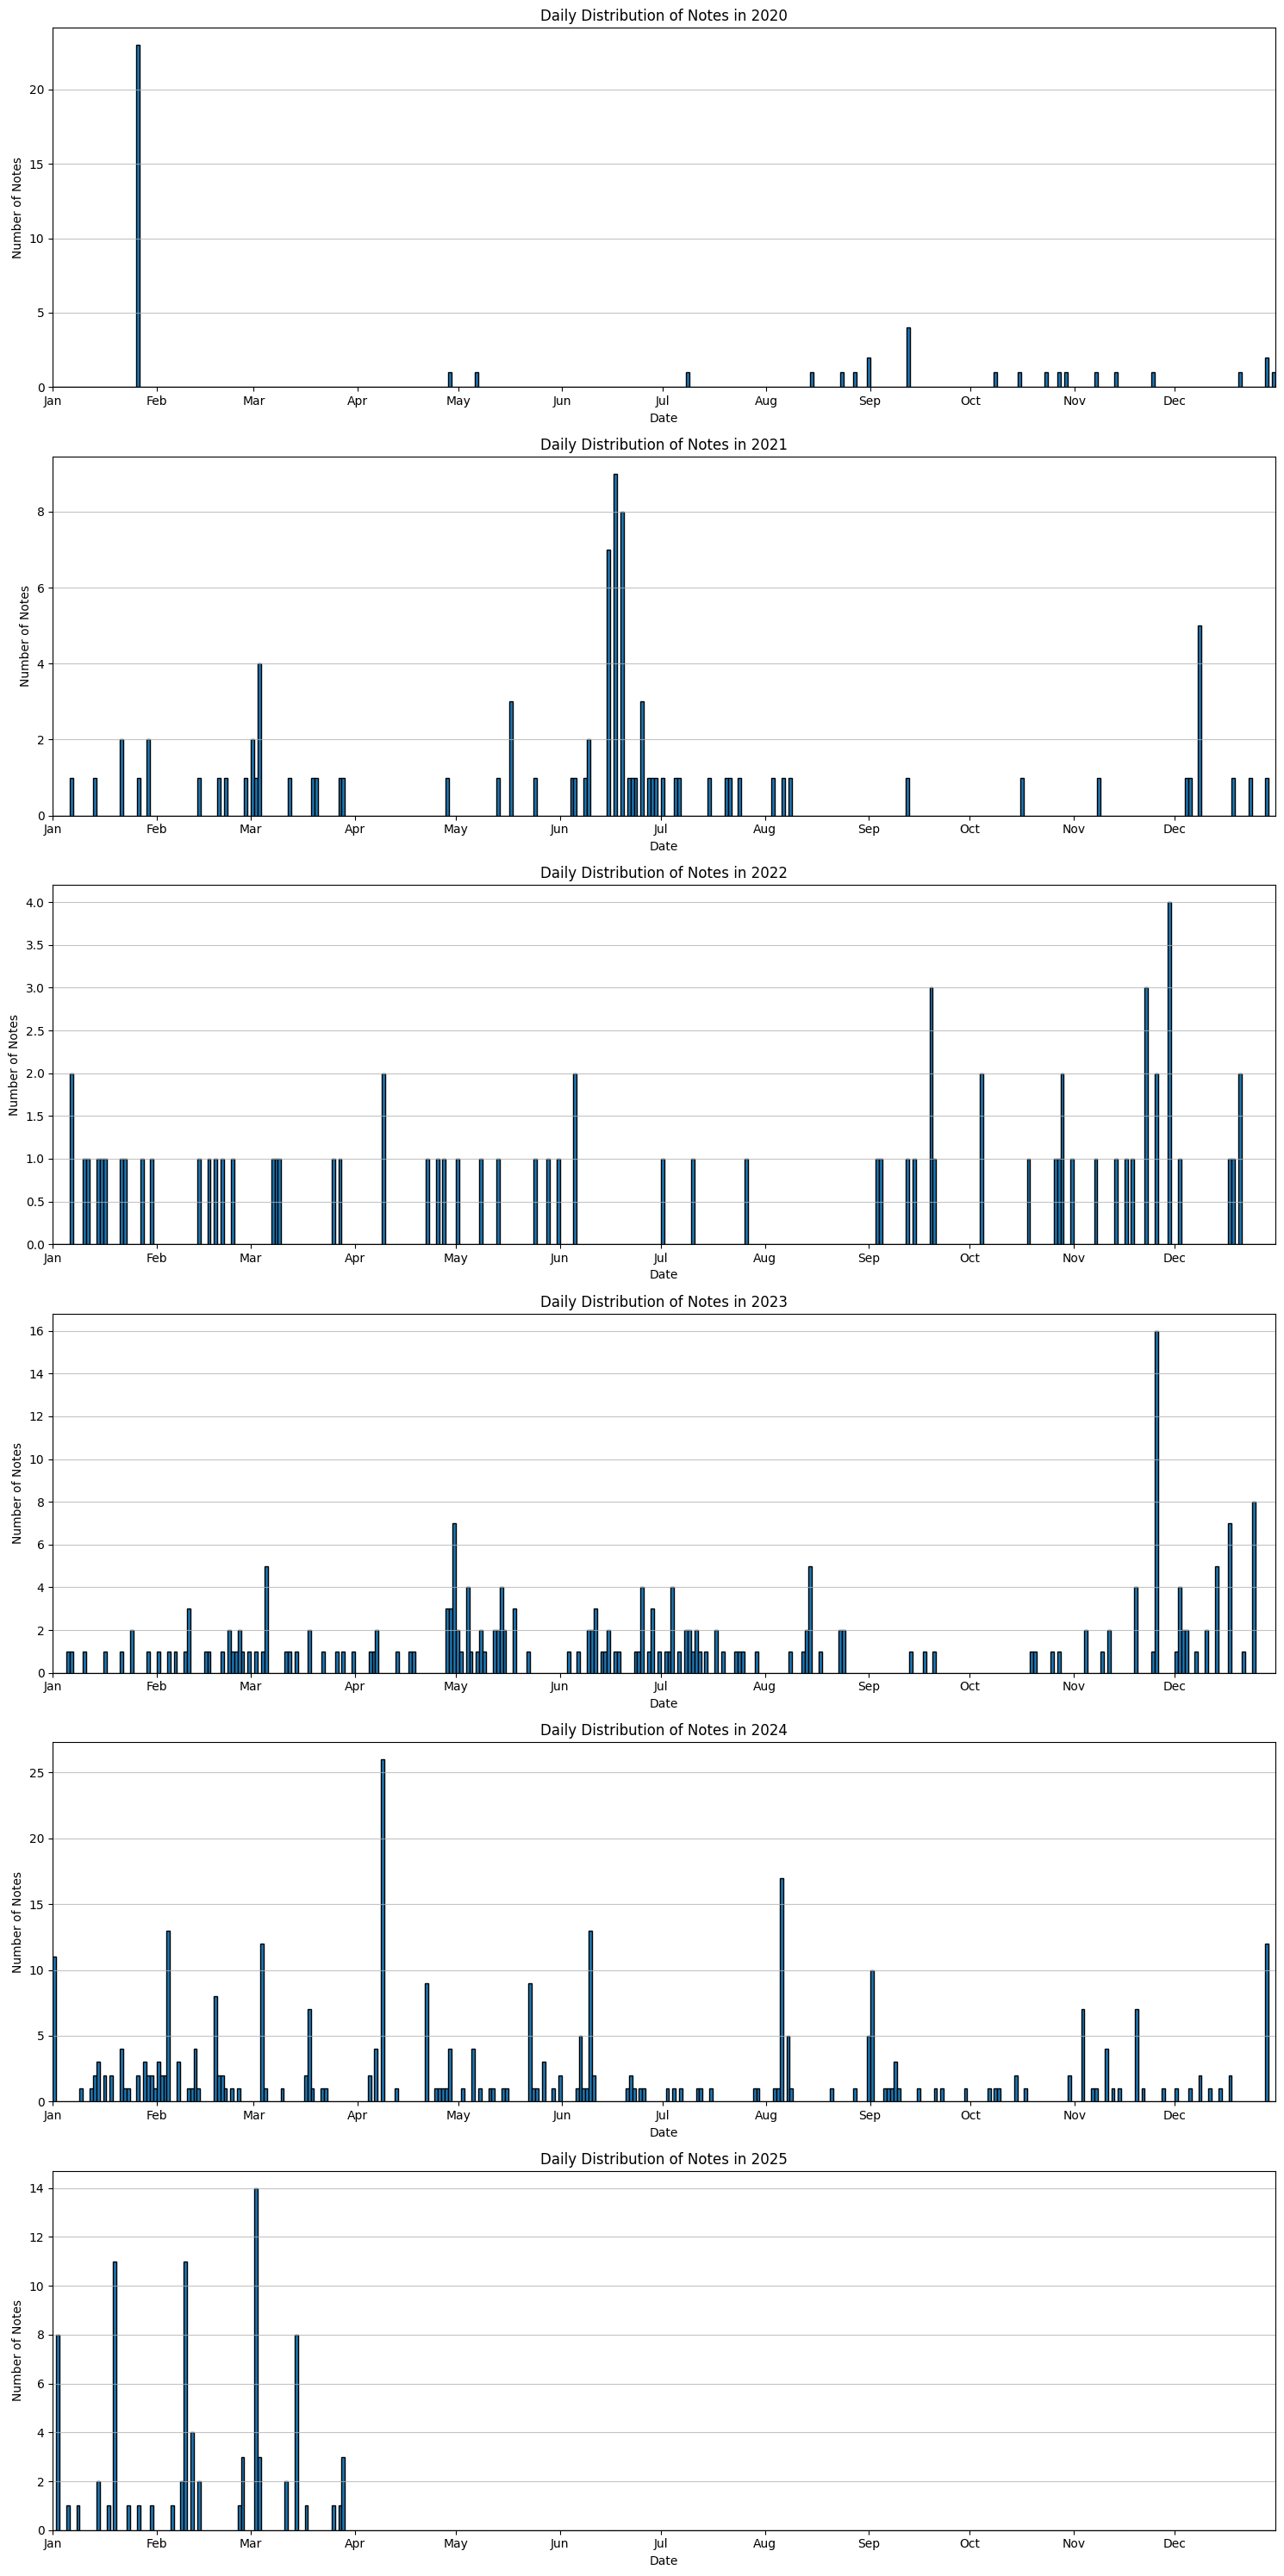

In [8]:
def plot_creation_dates_histogram(df, date_column='DateOfCreation'):
    """
    Plot daily histograms for each year in the data.
    
    Args:
        df (pd.DataFrame or pd.Series): DataFrame containing a date column or Series of dates
        date_column (str): Name of the column containing dates. Default is 'DateOfCreation'
    """
    # Handle both DataFrame and Series inputs
    if isinstance(df, pd.DataFrame):
        dates = df[date_column]
    else:
        dates = df
    
    # Convert to datetime
    dates = pd.to_datetime(dates)
    
    # Get unique years
    years = sorted(dates.dt.year.unique())
    
    # Create subplots for each year
    fig, axes = plt.subplots(len(years), 1, figsize=(15, 5*len(years)))
    if len(years) == 1:
        axes = [axes]  # Handle single year case
    
    for i, year in enumerate(years):
        # Filter dates for current year
        year_dates = dates[dates.dt.year == year]
        
        # Create daily histogram with fixed date range
        start_date = pd.Timestamp(f'{year}-01-01')
        end_date = pd.Timestamp(f'{year}-12-31')
        bins = pd.date_range(start=start_date, end=end_date, freq='D')
        
        axes[i].hist(year_dates, bins=bins, edgecolor='black')
        axes[i].set_title(f'Daily Distribution of Notes in {year}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Number of Notes')
        axes[i].grid(axis='y', alpha=0.75)
        
        # Set x-axis limits to cover the full year
        axes[i].set_xlim(start_date, end_date)
        
        # Format x-axis to show months
        axes[i].xaxis.set_major_locator(mdates.MonthLocator())
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    plt.tight_layout()
    plt.show()

# Plot the histogram for my_thoughts
plot_creation_dates_histogram(my_thoughts['DateOfCreation'])


In [27]:
def update_dates_from_body(df):
    """
    Update DateOfCreation based on dates found in Body column.
    Dates should be in format like 'feb 12', 'jan 1', etc.
    If year is not specified, keeps original year.
    Sets time to 10:00 AM.
    """
    # Dictionary to map month abbreviations to numbers
    month_map = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12,
        'january': 1, 'february': 2, 'march': 3, 'april': 4, 'june': 6,
        'july': 7, 'august': 8, 'september': 9, 'october': 10,
        'november': 11, 'december': 12
    }
    
    # Regular expression to match dates in various formats
    date_pattern = r'(jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s*(\d{1,2})(?:,\s*(\d{4}))?'
    
    modified_count = 0
    
    for idx, row in df.iterrows():
        if pd.isna(row['Body']):
            continue
            
        # Search for date pattern in Body
        matches = re.finditer(date_pattern, row['Body'].lower())
        
        for match in matches:
            month_str = match.group(1)
            day_str = match.group(2)
            year_str = match.group(3) if match.lastindex >= 3 else None
            
            try:
                month = month_map[month_str]
                day = int(day_str)
                
                # Get original date to keep year if not specified
                original_date = pd.to_datetime(row['DateOfCreation'])
                year = int(year_str) if year_str else original_date.year
                
                # Create new date with 10:00 AM
                new_date = pd.Timestamp(year=year, month=month, day=day, hour=10)
                
                # Update the date if it's different from original
                if new_date != original_date:
                    df.at[idx, 'DateOfCreation'] = new_date
                    print(f"Modified date for row {idx}: {original_date} -> {new_date}")
                    modified_count += 1
                    break  # Only use first match found
            except (KeyError, ValueError) as e:
                print(f"Error processing date in row {idx}: {e}")
                print(f"Body content: {row['Body']}")
                continue
    
    print(f"Total modifications: {modified_count}")
    return df


In [28]:
y_thoughts = update_dates_from_body(my_thoughts)


Modified date for row 1236: 2025-03-28 10:26:29 -> 2025-03-27 10:00:00
Modified date for row 1240: 2025-03-14 09:06:29 -> 2025-03-09 10:00:00
Modified date for row 1241: 2025-03-14 09:05:52 -> 2025-03-09 10:00:00
Modified date for row 1242: 2025-03-14 09:05:23 -> 2025-03-09 10:00:00
Modified date for row 1243: 2025-03-14 09:04:38 -> 2025-03-06 10:00:00
Modified date for row 1244: 2025-03-14 09:04:12 -> 2025-03-06 10:00:00
Modified date for row 1245: 2025-03-14 09:03:48 -> 2025-03-06 10:00:00
Modified date for row 1246: 2025-03-14 09:03:14 -> 2025-03-06 10:00:00
Modified date for row 1247: 2025-03-14 08:59:03 -> 2025-03-02 10:00:00
Modified date for row 1253: 2025-03-02 11:42:27 -> 2025-02-27 10:00:00
Modified date for row 1254: 2025-03-02 11:03:42 -> 2025-02-19 10:00:00
Modified date for row 1255: 2025-03-02 11:02:48 -> 2025-02-19 10:00:00
Modified date for row 1256: 2025-03-02 10:57:06 -> 2025-02-19 10:00:00
Modified date for row 1257: 2025-03-02 10:55:29 -> 2025-02-18 10:00:00
Modifi

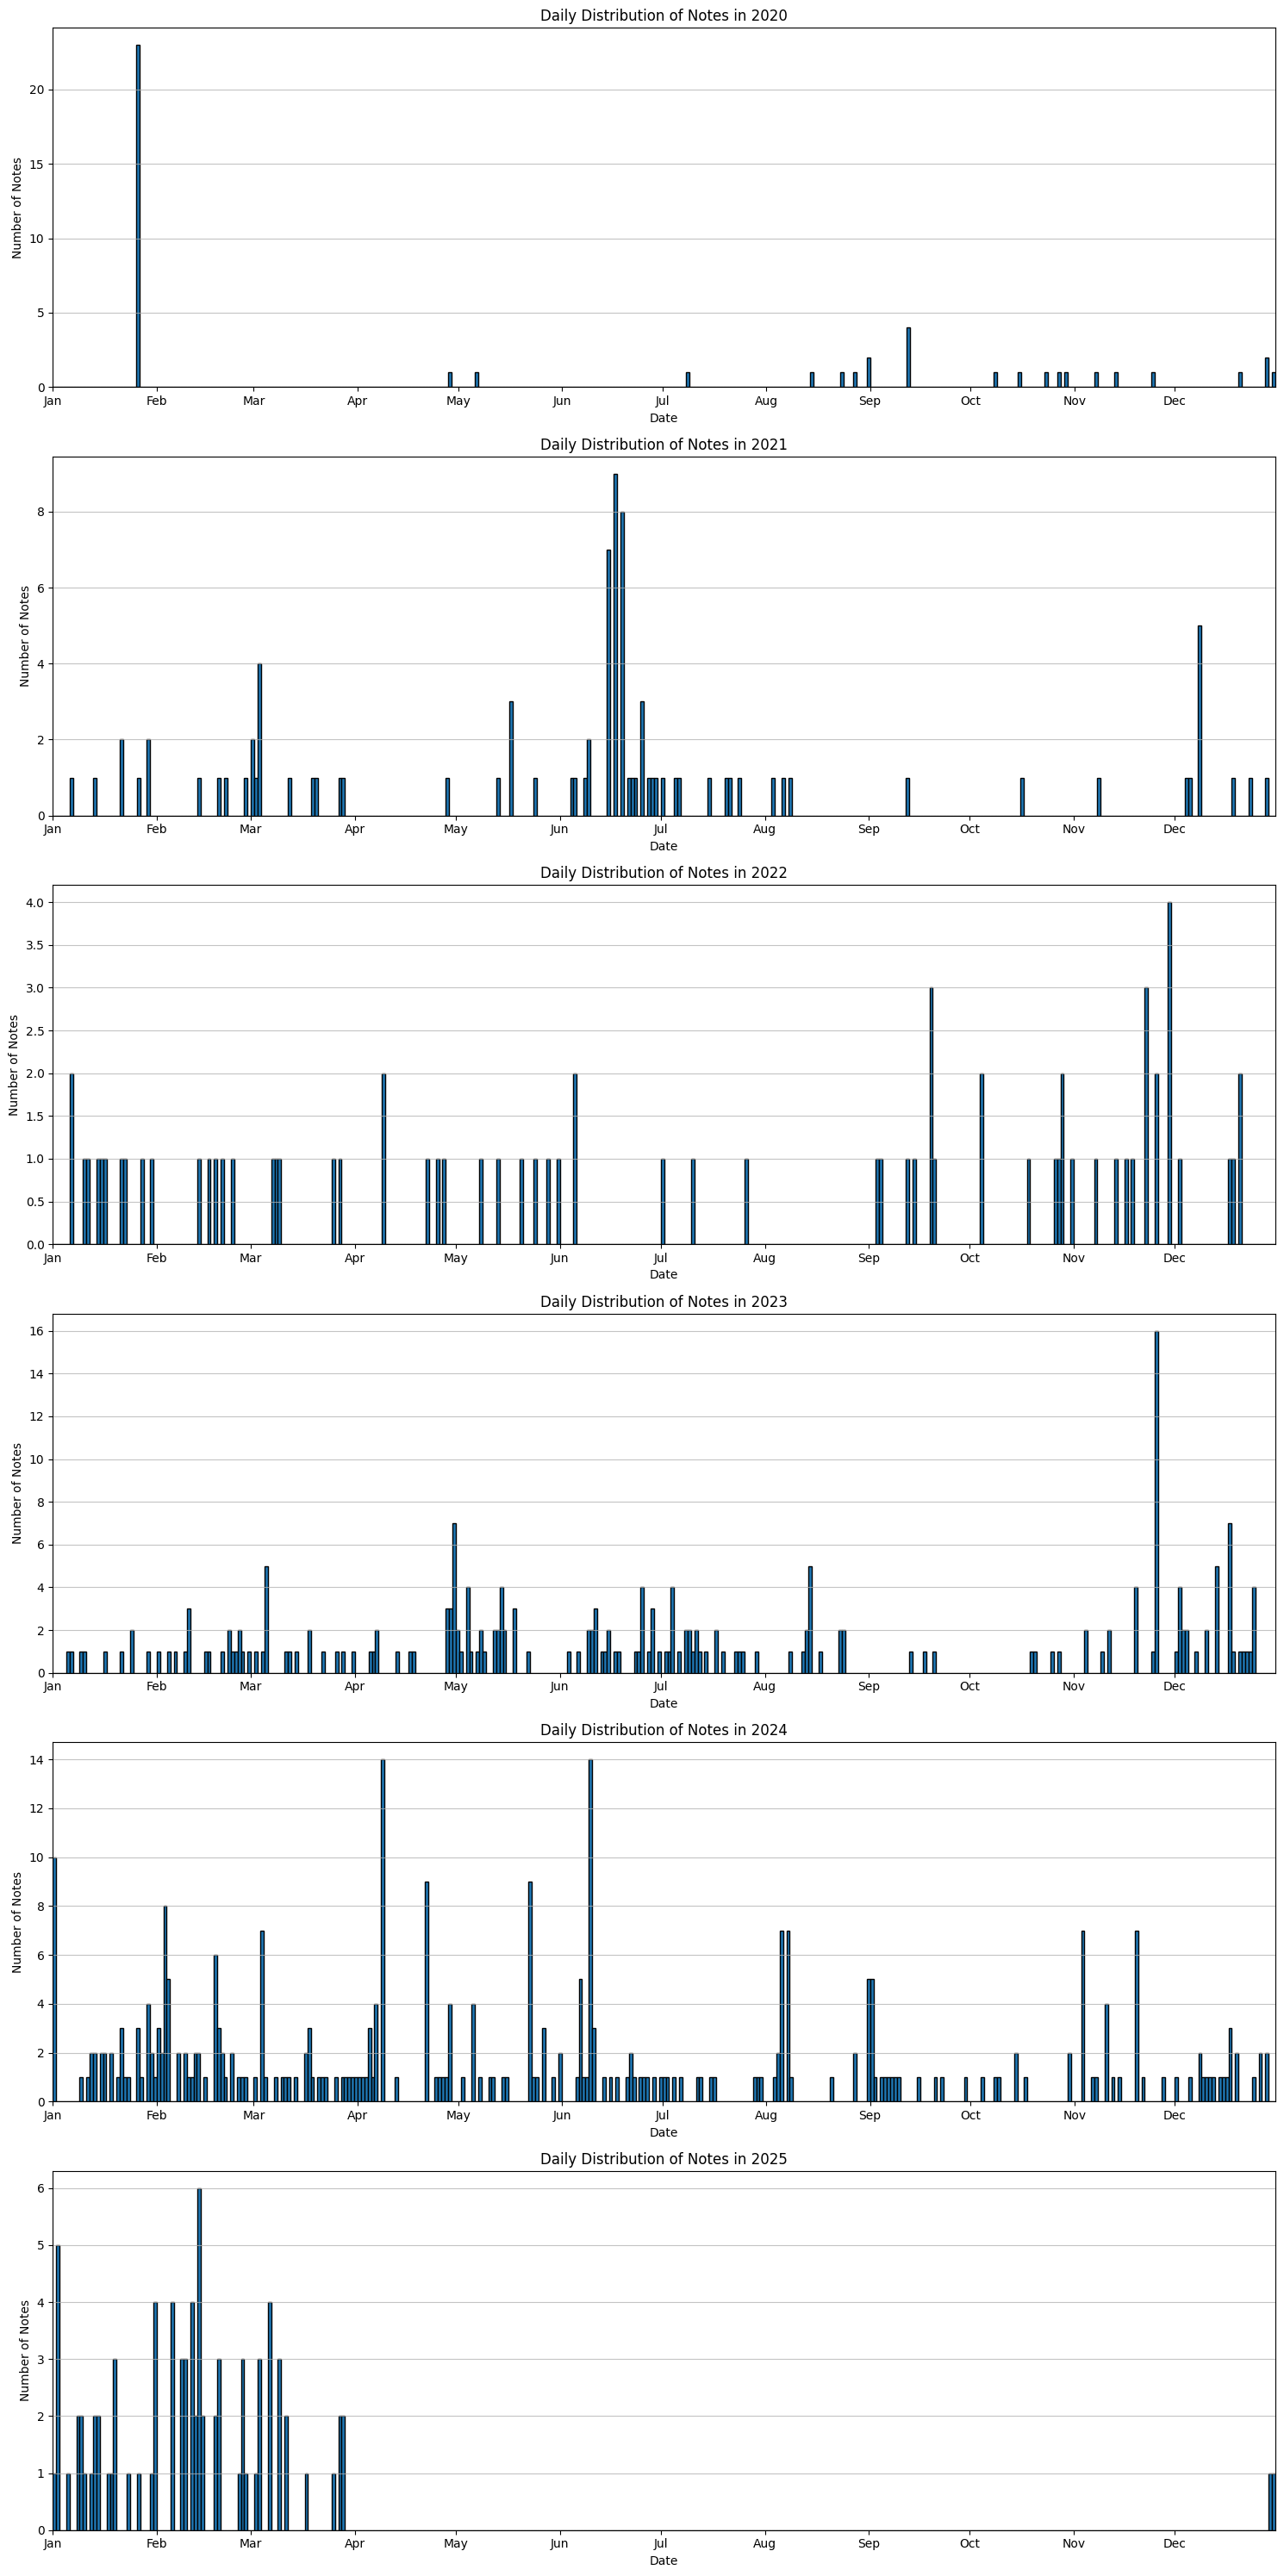

In [29]:
def plot_creation_dates_histogram(df, date_column='DateOfCreation'):
    """
    Plot daily histograms for each year in the data.
    
    Args:
        df (pd.DataFrame or pd.Series): DataFrame containing a date column or Series of dates
        date_column (str): Name of the column containing dates. Default is 'DateOfCreation'
    """
    # Handle both DataFrame and Series inputs
    if isinstance(df, pd.DataFrame):
        dates = df[date_column]
    else:
        dates = df
    
    # Convert to datetime
    dates = pd.to_datetime(dates)
    
    # Get unique years
    years = sorted(dates.dt.year.unique())
    
    # Create subplots for each year
    fig, axes = plt.subplots(len(years), 1, figsize=(15, 5*len(years)))
    if len(years) == 1:
        axes = [axes]  # Handle single year case
    
    for i, year in enumerate(years):
        # Filter dates for current year
        year_dates = dates[dates.dt.year == year]
        
        # Create daily histogram with fixed date range
        start_date = pd.Timestamp(f'{year}-01-01')
        end_date = pd.Timestamp(f'{year}-12-31')
        bins = pd.date_range(start=start_date, end=end_date, freq='D')
        
        axes[i].hist(year_dates, bins=bins, edgecolor='black')
        axes[i].set_title(f'Daily Distribution of Notes in {year}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Number of Notes')
        axes[i].grid(axis='y', alpha=0.75)
        
        # Set x-axis limits to cover the full year
        axes[i].set_xlim(start_date, end_date)
        
        # Format x-axis to show months
        axes[i].xaxis.set_major_locator(mdates.MonthLocator())
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    plt.tight_layout()
    plt.show()

# Plot the histogram for my_thoughts
plot_creation_dates_histogram(my_thoughts['DateOfCreation'])
